# EDSA Apple Prices Challenge

Regression_AM2_DSFT team is determined to help the Fresh Produce Industry to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

In the Fresh Produce Industry, having the right amount of stock on hand is crucial. That's, not having too little that you run out of stock when customers want to buy more. And not having too much that food waste occurs. Yields from farms fluctuate by season. Should the prices then also fluctuate by season? The is a need for a more accurate method to determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

Regression_AM2_DSFT will investigate key factors that have a great impact on the price of the Golden Delicious Apples to be maximised. We will construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

![Golden Apples](apples.png)

## Data Cleaning and Formatting
Before we do anything, we first have to clean our data.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

### Datasets

In [2]:
df_test = pd.read_csv("df-test_set.csv")
df_train = pd.read_csv("df-train_set.csv")

**Let's first take a look at our training data**

In [3]:
df_train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In [4]:
df_train.shape

(64376, 13)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          64376 non-null  object 
 1   Container         64376 non-null  object 
 2   Size_Grade        64376 non-null  object 
 3   Weight_Kg         64376 non-null  float64
 4   Commodities       64376 non-null  object 
 5   Date              64376 non-null  object 
 6   Low_Price         64376 non-null  float64
 7   High_Price        64376 non-null  float64
 8   Sales_Total       64376 non-null  float64
 9   Total_Qty_Sold    64376 non-null  int64  
 10  Total_Kg_Sold     64376 non-null  float64
 11  Stock_On_Hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


In [6]:
df_train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,64376.000000,64376.000000,64376.000000,6.437600e+04,64376.000000,64376.000000,64376.000000,64376.00
mean,12.781592,75.651938,89.607858,1.939501e+04,446.104402,3336.641295,477.646328,NaN
std,35.943052,159.508144,172.223177,4.442192e+04,1184.169758,7682.295441,1453.892091,NaN
min,0.120000,1.000000,1.000000,-5.770000e+04,-595.000000,-5040.000000,-512.000000,-inf
25%,7.000000,30.000000,35.000000,1.154000e+03,20.000000,175.000000,0.000000,4.02
50%,10.000000,46.000000,55.000000,5.400000e+03,107.000000,940.000000,76.000000,6.00
75%,11.000000,80.000000,100.000000,1.877200e+04,390.000000,3250.000000,381.000000,8.67
max,500.000000,4400.000000,4400.000000,1.134701e+06,39453.000000,192230.000000,93193.000000,inf


#### Test Data

In [7]:
df_test.head(2)

,Index,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,1,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,APPLE GOLDEN DELICIOUS,09/07/2020,128.0,136.0,5008.0,38,456.0,0
1,2,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,APPLE GOLDEN DELICIOUS,20/01/2020,220.0,220.0,1760.0,8,146.4,2


In [8]:
df_test = df_test.drop(columns = ['Index'])
df_test.head(2)

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,APPLE GOLDEN DELICIOUS,09/07/2020,128.0,136.0,5008.0,38,456.0,0
1,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,APPLE GOLDEN DELICIOUS,20/01/2020,220.0,220.0,1760.0,8,146.4,2


In [9]:
df_test.shape

(685, 12)

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province        685 non-null    object 
 1   Container       685 non-null    object 
 2   Size_Grade      685 non-null    object 
 3   Weight_Kg       685 non-null    float64
 4   Commodities     685 non-null    object 
 5   Date            685 non-null    object 
 6   Low_Price       685 non-null    float64
 7   High_Price      685 non-null    float64
 8   Sales_Total     685 non-null    float64
 9   Total_Qty_Sold  685 non-null    int64  
 10  Total_Kg_Sold   685 non-null    float64
 11  Stock_On_Hand   685 non-null    int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 64.3+ KB


In [11]:
df_test.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,34.142482,164.202891,195.590073,18788.111212,174.883212,2725.402336,439.245255
std,87.575995,355.167319,389.109476,33951.586813,299.351142,5059.123311,715.985761
min,3.000000,10.000000,10.000000,10.000000,1.000000,6.300000,0.000000
25%,9.000000,50.000000,64.000000,1300.000000,13.000000,204.000000,20.000000
50%,12.000000,80.000000,112.000000,5520.000000,62.000000,860.100000,153.000000
75%,18.300000,128.000000,160.000000,21176.000000,200.000000,3033.000000,516.000000
max,400.000000,2400.000000,2400.000000,308010.000000,2774.000000,47200.000000,6827.000000


### Seasons Generating Function

In [12]:
def season(x, date_format):
    date_str = [str(i) for i in x]
    months = [datetime.strptime(i, date_format).month for i in date_str]
    
    dict_ = {1: 'Summer',
             2: 'Summer',
             3: 'Autumn',
             4: 'Autumn',
             5: 'Autumn',
             6: 'Winter',
             7: 'Winter',
             8: 'Winter',
             9: 'Spring',
             10: 'Spring',
             11: 'Spring',
             12: 'Summer'}
    
    seasons = [dict_[month] for month in months] 
    
    return seasons

In [13]:
df_test['Season'] = pd.DataFrame(season(df_test.Date, '%d/%m/%Y'))
df_test.head(2)

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Season
0,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,APPLE GOLDEN DELICIOUS,09/07/2020,128.0,136.0,5008.0,38,456.0,0,Winter
1,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,APPLE GOLDEN DELICIOUS,20/01/2020,220.0,220.0,1760.0,8,146.4,2,Summer


Since we don't need the date column anymore, we can drop it

In [14]:
df_test = df_test.drop(columns = ['Date'])

In [15]:
df_train['Season'] = pd.DataFrame(season(df_train.Date, '%Y-%m-%d'))
df_train.head(2)

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,Season
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30,Autumn
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51,Spring


Let's drop the date column

In [16]:
df_train = df_train.drop(columns = ['Date'])

## Exploratory Data Analysis

<AxesSubplot:>

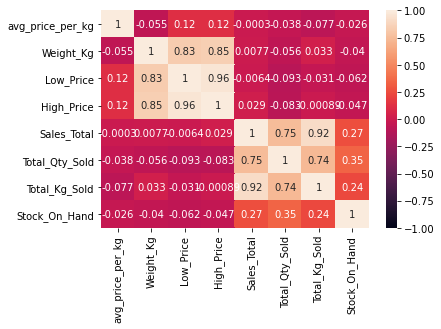

In [17]:
sns.heatmap(df_train[['avg_price_per_kg', 'Weight_Kg', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand']].corr(), vmin = -1, vmax = 1, annot = True)

In [18]:
#plt.boxplot(df_train['avg_price_per_kg'], hue = 'Season')

## Feature Engineering

### Dummy Variables

In [19]:
df_train = pd.get_dummies(df_train)
df_train.head()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg,Province_CAPE,Province_EASTERN CAPE,...,Commodities_TOMATOES OTHER,Commodities_TOMATOES SALADETTE,Commodities_TOMATOES-LONG LIFE,Commodities_VALLEY GOLD,Commodities_WASHED POTATOES,Commodities_WATERMELON,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,12.0,108.0,112.0,3236.0,29,348.0,0,9.30,1,0,...,0,0,0,0,0,0,1,0,0,0
1,18.3,150.0,170.0,51710.0,332,6075.6,822,8.51,1,0,...,0,0,0,0,0,0,0,1,0,0
2,20.0,70.0,80.0,4860.0,66,1320.0,50,3.68,0,0,...,0,0,0,0,0,0,1,0,0,0
3,9.0,60.0,60.0,600.0,10,90.0,0,6.67,0,0,...,0,0,1,0,0,0,0,0,1,0
4,10.0,40.0,45.0,41530.0,927,9270.0,393,4.48,0,0,...,0,0,0,0,0,0,0,0,0,1
